# Code to put in appendix

Code written by Birendra Khimding and Andrew Fennimore

Github: https://github.com/Fenn3963/Weather-Impact-on-Air-Traffic-Management

In [86]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import statsmodels.formula.api as smf
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Retreive data from MJX

In [64]:
# pull from the MJX
url = "https://raw.githubusercontent.com/Fenn3963/Weather-Impact-on-Air-Traffic-Management/refs/heads/main/MJX.csv"

#All values with na are labeled as M
weather = pd.read_csv("MJX.csv" , na_values= "M")

### Create dictionary for descriptive stats and other pertinant information

In [66]:
# Column descriptions dictionary, retreived directly from https://mesonet.agron.iastate.edu/request/download.phtml?network=NJ_ASOS
column_descriptions = {
    "station": "Three or four character site identifier",
    "valid": "Timestamp of the observation",
    "tmpf": "Air Temperature in Fahrenheit, typically @ 2 meters",
    "dwpf": "Dew Point Temperature in Fahrenheit, typically @ 2 meters",
    "relh": "Relative Humidity in %",
    "drct": "Wind Direction in degrees from *true* north",
    "sknt": "Wind Speed in knots",
    "p01i": "One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.",
    "alti": "Pressure altimeter in inches",
    "mslp": "Sea Level Pressure in millibar",
    "vsby": "Visibility in miles",
    "gust": "Wind Gust in knots",
    "skyc1": "Sky Level 1 Coverage",
    "skyc2": "Sky Level 2 Coverage",
    "skyc3": "Sky Level 3 Coverage",
    "skyc4": "Sky Level 4 Coverage",
    "skyl1": "Sky Level 1 Altitude in feet",
    "skyl2": "Sky Level 2 Altitude in feet",
    "skyl3": "Sky Level 3 Altitude in feet",
    "skyl4": "Sky Level 4 Altitude in feet",
    "wxcodes": "Present Weather Codes (space separated)",
    "feel": "Apparent Temperature (Wind Chill or Heat Index) in Fahrenheit",
    "ice_accretion_1hr": "Ice Accretion over 1 Hour (inches)",
    "ice_accretion_3hr": "Ice Accretion over 3 Hours (inches)",
    "ice_accretion_6hr": "Ice Accretion over 6 Hours (inches)",
    "peak_wind_gust": "Peak Wind Gust (from PK WND METAR remark) (knots)",
    "peak_wind_drct": "Peak Wind Gust Direction (from PK WND METAR remark) (deg)",
    "peak_wind_time": "Peak Wind Gust Time (from PK WND METAR remark)",
    "metar": "Unprocessed reported observation in METAR format"
}

#################################################################################################
# Split up the quantitative and qualitative data
quant = weather.select_dtypes(include=["number"])
qual = weather.select_dtypes(exclude=["number"])

# create dictionary of the statsistical information and descriptions
stats_dict = {}

#################################################################################################

# Quantitative stats
for col in quant.columns:
    mode_values = quant[col].mode().dropna().tolist()
    if mode_values:
        mode = mode_values
    else:
        mode = None
    
    # Calculate stats and give description
    count = quant[col].count()
    mean = round(quant[col].mean(), 2)
    median = round(quant[col].median(), 2)
    std = round(quant[col].std(), 2)
    data_type = "Quantitative"
    description = column_descriptions.get(col)
    
    # Find the percentage of null values
    null_percentage = round((quant[col].isnull().sum() / len(quant[col])) * 100, 2) #find percentage of values with "none"

    # Create stats dictionary
    stats = {
        "Description": description,
        "Data Type": data_type,
        "Count": count,
        "Mean": mean,
        "Median": median,
        "Std": std,
        "Mode": mode,
        "Null Percentage": f"{null_percentage}%"  #% that doesn't have values
    }
    
    # Filter out None values to then store in the dictionary, used to calculate percentage 
    stats_filtered = {}
    for k, v in stats.items():
        if v is not None:
            stats_filtered[k] = v

    stats_dict[col] = stats_filtered
    
#################################################################################################

# Qualitative stats
for col in qual.columns:
    mode_values = qual[col].mode().dropna().tolist()
    
    # If every value is unique, set mode to None
    if len(mode_values) == len(qual[col].dropna().unique()):
        mode_output = None
    else:
        if mode_values:
            mode_output = mode_values
        else:
            mode_output = None

    # Get the count 
    if mode_output is not None:
        most_frequent_count = qual[col].value_counts().iloc[0]
    else:
        most_frequent_count = None
    
    # Calculate all the stats for qualitative portion
    count = qual[col].count()
    unique_values = qual[col].nunique()
    data_type = "Qualitative"
    description = column_descriptions.get(col, "No description available")
    
    # Calculate the percentage of null values
    null_percentage = round((qual[col].isnull().sum() / len(qual[col])) * 100, 2) #find percentage of values with the none value

    # Create stats dictionary
    stats = {
        "Description": description,
        "Data Type": data_type,
        "Count": count,
        "Mode": mode_output,
        "Unique Values": unique_values,
        "Most Frequent Count": most_frequent_count,
        "Null Percentage": f"{null_percentage}%"
    }
    
    # Filter out None values and store in stats_dict
    stats_filtered = {}
    for k, v in stats.items():
        if v is not None:
            stats_filtered[k] = v
    stats_dict[col] = stats_filtered 

#################################################################################################

# Print in green
html_code = '<p style="font-size:20px; color:green;">Description of columns:</p>'
display(HTML(html_code)) #makes it look nicer 

"""
#print all of the variables and statistics associated
for col, stats in stats_dict.items():
    print(f"\nStatistics for '{col}':")
    for key, value in stats.items():
        print(f"  {key}: {value}")
"""


'\n#print all of the variables and statistics associated\nfor col, stats in stats_dict.items():\n    print(f"\nStatistics for \'{col}\':")\n    for key, value in stats.items():\n        print(f"  {key}: {value}")\n'

### Creating seperate charts of the stats so it is easier to view

In [68]:
#This will create seperate external files based on the data information


#Create a seperate csv file of dictionary so it is easier to view
des_chart = pd.DataFrame(stats_dict).T  # transpose to have variables as rows

# Drop the description since I am putting it in another seperate csv
if "Description" in des_chart.columns:
    des_chart = des_chart.drop(columns=["Description"])

# filename used, can easily change if need be
filename = "weather_variables.csv"

# Save as csv to a whole new file
des_chart.to_csv(filename, index=True)

In [69]:
#Creates a separate csv to show variable's descriptions
descriptions = pd.DataFrame(list(column_descriptions.items()), columns=["Variable", "Description"]) #single out the descriptions from the dictionary

# Define the CSV filename
filename = "variable_descriptions.csv"
descriptions.to_csv(filename, index=False) 

#### Dealing with missing data

In [71]:
# Number of Missing vlaues in the dataframe
weather.isna().sum()

station                  0
valid                    0
tmpf                     5
dwpf                     7
relh                     7
drct                   282
sknt                     8
p01i                     3
alti                   111
mslp                  2495
vsby                     1
gust                  9568
skyc1                   30
skyc2                 9246
skyc3                10618
skyc4                11423
skyl1                 4939
skyl2                 9246
skyl3                10618
skyl4                11423
wxcodes               9072
ice_accretion_1hr    11423
ice_accretion_3hr    11423
ice_accretion_6hr    11423
peak_wind_gust       10971
peak_wind_drct       10971
peak_wind_time       10971
feel                     9
metar                    0
snowdepth            11423
dtype: int64

In [72]:
# Setting a threshold to remove any column with more then 15% missing value
threshold = len(weather)*.15
cols_drop_nan = weather.columns[weather.isna().sum() <= threshold]

# Drop row with missing values
weather.dropna(subset=cols_drop_nan, inplace=True)

# Droping columns with more then 15% missing values

cols_to_drop = weather.columns[weather.isna().sum() > 0]
print(cols_to_drop)
weather.drop(columns=cols_to_drop , inplace=True)

Index(['mslp', 'gust', 'skyc2', 'skyc3', 'skyc4', 'skyl1', 'skyl2', 'skyl3',
       'skyl4', 'wxcodes', 'ice_accretion_1hr', 'ice_accretion_3hr',
       'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct',
       'peak_wind_time', 'snowdepth'],
      dtype='object')


#### OLS Model 

In [74]:
#put here since it uses old variables
# Model 1: Predict visibility using various weather variables
model = smf.ols(formula="vsby ~ tmpf + relh + sknt + alti + C(skyc1)", data=weather).fit()

# Print summary of the model
print(model.summary())

#Inversing and transforming to deal with negative skew
import numpy as np
import statsmodels.formula.api as smf

# tyring an inverse log tranformation
K = weather["vsby"].max() + 1
weather["reflect_log_vsby"] = np.log(K - weather["vsby"])

# Fit the ols model using the new variable
model = smf.ols(formula="reflect_log_vsby ~ tmpf + relh + sknt + alti + C(skyc1)", data=weather).fit()

# View the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   vsby   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     412.2
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:40:25   Log-Likelihood:                -24505.
No. Observations:               10996   AIC:                         4.903e+04
Df Residuals:                   10986   BIC:                         4.910e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.5139      3.209     

#### Improving data readability and accessibility

In [76]:
weather.rename(columns={'valid': 'timestamp', 'tmpf': 'air_temperature','dwpf':'dew_temperature', 'relh':'humidity', 'drct':'wind_direction', 'sknt':'wind_speed', 'p01i':'one_hour_precp' , 'alti':'pressure_altimeter', 'vsby':'visibility', 'skyc1':'cloud_coverage', 'feel':'apparent_temp', 'metar':'unprocessed_observation'  } , inplace=True)
weather.columns

#Replacing Char value to float 
weather['one_hour_precp'] = weather['one_hour_precp'].replace('T', '0.001')

#Changing the one_hour_precp column data type to float
weather['one_hour_precp'] = weather['one_hour_precp'].astype(float)

# Checking for number of 0.0 vlueas in the dataframe
col_with_zeor = (weather == 0.0).sum()
print(col_with_zeor)


station                       0
timestamp                     0
air_temperature               1
dew_temperature              17
humidity                      0
wind_direction             2413
wind_speed                 2413
one_hour_precp             9015
pressure_altimeter            0
visibility                    0
cloud_coverage                0
apparent_temp                 1
unprocessed_observation       0
reflect_log_vsby           8928
dtype: int64


#### Univariate EDA (Single Variable Analysis)

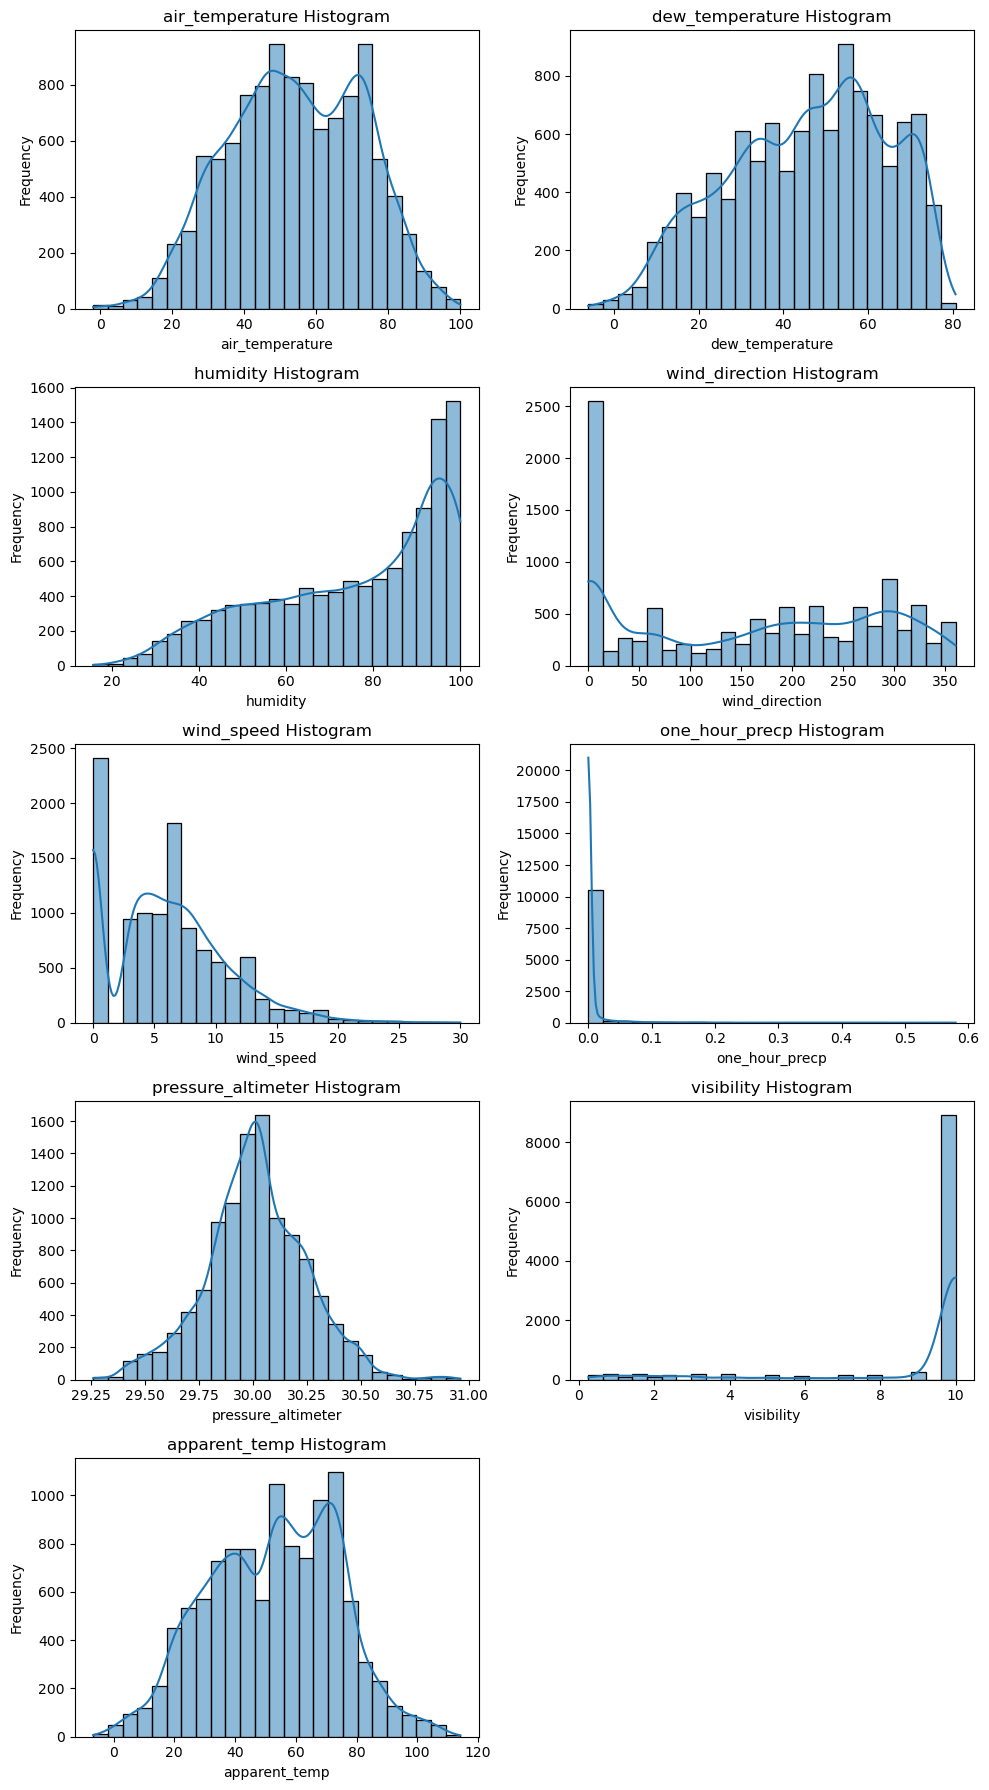

In [78]:
# Univariate EDA (Single Variable Analysis)

# Histogram for all the Numerical Column
import seaborn as sns 
import matplotlib.pyplot as plt 

columns_to_plot = ['air_temperature', 'dew_temperature', 'humidity','wind_direction' ,'wind_speed', 'one_hour_precp', 'pressure_altimeter', 'visibility', 'apparent_temp']

fig, axes = plt.subplots(5, 2, figsize=(10, 18)) 
axes = axes.flatten()
for i, col in enumerate(columns_to_plot):
    sns.histplot(weather[col], kde=True, ax=axes[i], bins=25)  # kde=True adds a density curve
    axes[i].set_title(f'{col} Histogram')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

if len(columns_to_plot) < len(axes):
    axes[-1].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

#### Box plot for all the numerical columns

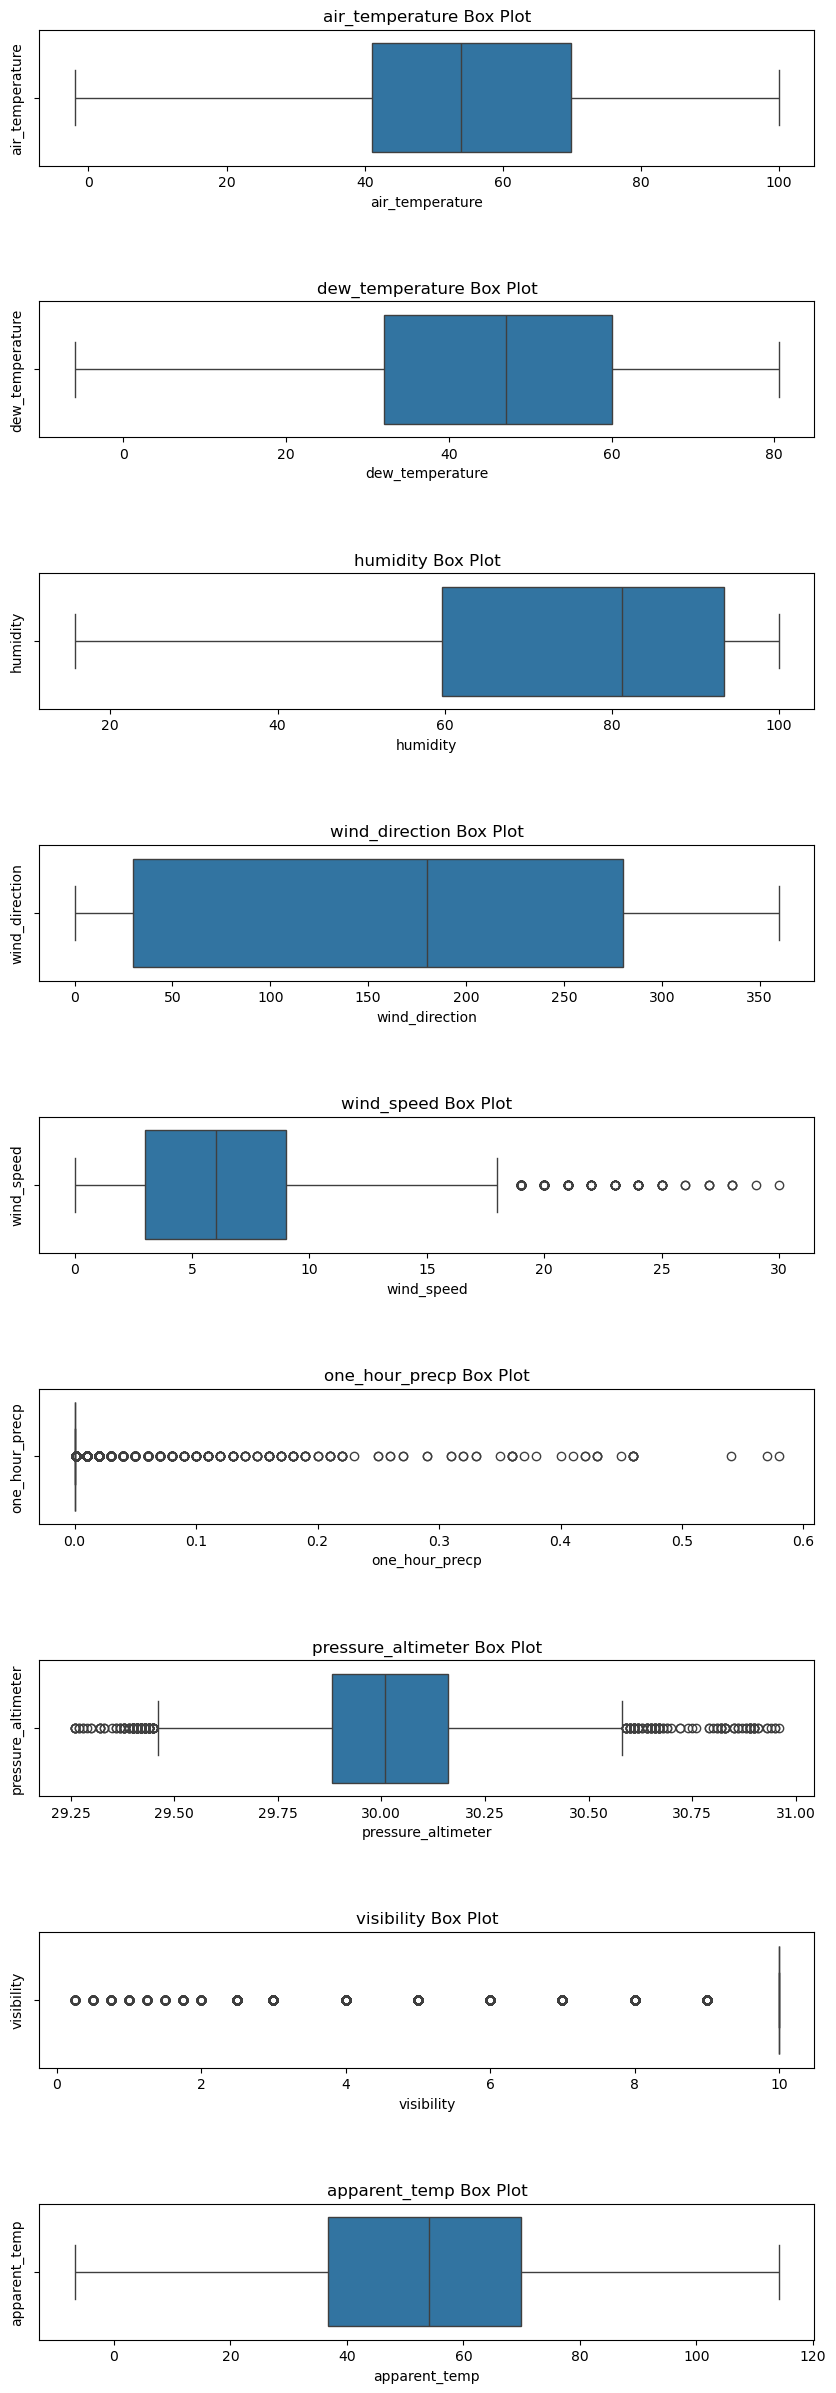

In [80]:
fig, axes = plt.subplots(9, 1, figsize=(10, 30))  
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    if col in weather.columns:
        sns.boxplot(x=weather[col], ax=axes[i])  # Box plot for each variable
        axes[i].set_title(f'{col} Box Plot')
        axes[i].set_ylabel(col)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Hide the last unused subplot if necessary
if len(columns_to_plot) < len(axes):
    axes[-1].set_visible(False)

plt.subplots_adjust(hspace=1)
plt.show()

#### Bivariate EDA (Two Variable Analysis)


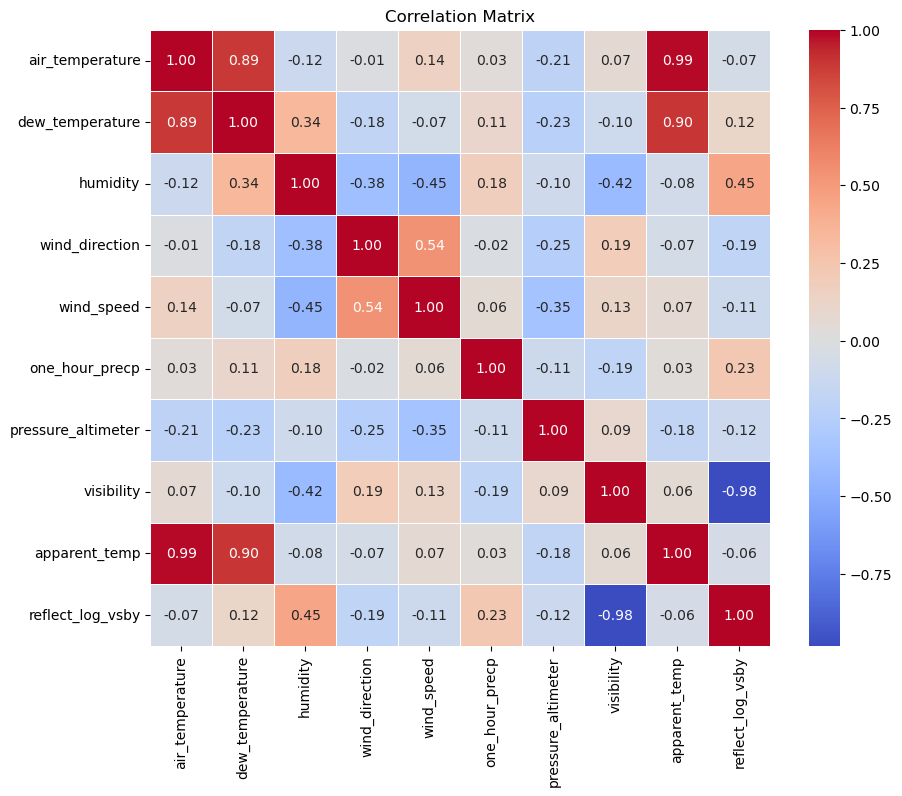

In [82]:
#Bivariate EDA (Two Variable Analysis)

# Drop non-numeric columns
weather_numeric = weather.select_dtypes(include=['number'])

# The correlation matrix
correlation_matrix = weather_numeric.corr()

# Cloud_coverage and Visibility
visibility_by_cloud = weather.groupby('cloud_coverage')['visibility'].mean()

# Visibility with all other Numerical columns
pairs_to_plot = [
    ('air_temperature', 'visibility'),
    ('humidity', 'visibility'),
    ('wind_speed', 'visibility'),
    ('dew_temperature', 'visibility'),
    ('one_hour_precp', 'visibility'),
    ('pressure_altimeter', 'visibility')
]

# Multivariate EDA (Multiple Variables Analysis)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [83]:
#Change the Cloud catagorical data to ordinal numerical data
# Create a dictionary to map each category
ordinal_mapping = {
    'CLR': 0,
    'FEW': 1,
    'SCT': 2,
    'BKN': 3,
    'OVC': 4,
    'VV': 5
}

weather['cloud_ordinal']= weather['cloud_coverage'].map(ordinal_mapping)
weather['cloud_ordinal'].value_counts()
weather = weather.dropna(subset=['cloud_ordinal'])

# Slpit the data into Dependent and Independent variable 
x = weather.drop(columns=['visibility', 'cloud_coverage', 'station', 'timestamp', 'unprocessed_observation', 'dew_temperature' , 'apparent_temp', 'wind_direction', 'pressure_altimeter', 'wind_speed'])
y = weather['visibility']

# Taing the data using 80% and predicting the 20% x data with the y
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#### GLM model

In [84]:
#Using GLM for Model Selectin becuase our dependent data is not normal and is skewed.
# GLM with out interection
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add intercept
x_const = sm.add_constant(x_train)

# Apply log to Y
y_log_transformed = np.log1p(y_train)

# Gamma GLM 
glm_no_interaction = sm.GLM(y_log_transformed, x_const, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
print(glm_no_interaction.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             visibility   No. Observations:                 8787
Model:                            GLM   Df Residuals:                     8781
Model Family:                   Gamma   Df Model:                            5
Link Function:                    Log   Scale:                        0.020553
Method:                          IRLS   Log-Likelihood:                -3607.0
Date:                Sun, 23 Feb 2025   Deviance:                       243.46
Time:                        17:40:27   Pearson chi2:                     180.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.9271
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8398      0.008  

In [88]:
# VIF for each Predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = x_train.columns
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(len(x_train.columns))]


print(vif_data)

            Feature       VIF
0   air_temperature  5.742731
1          humidity  7.306205
2    one_hour_precp  1.092184
3  reflect_log_vsby  1.599495
4     cloud_ordinal  2.510221


In [90]:
# Test the Gamma Model
x_test_const = sm.add_constant(x_test)
x_predict = glm_no_interaction.predict(x_test_const)
x_predict_exp = np.expm1(x_predict)

# Check the performace of the Model

mae = mean_absolute_error(y_test, x_predict_exp)
r2 = r2_score(y_test, x_predict_exp)


Mean Absolute Error (MAE): 0.7248092889421853
r2_score (MAE): 0.6452686254306526


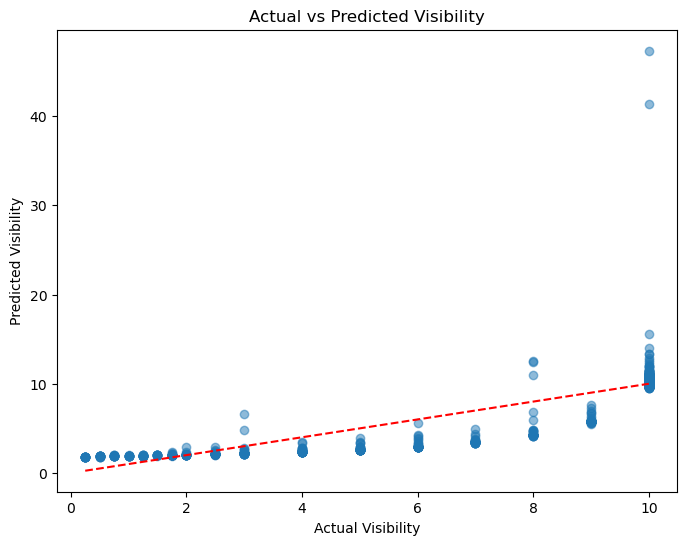

In [92]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, x_predict_exp, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Visibility')
plt.ylabel('Predicted Visibility')
plt.title('Actual vs Predicted Visibility')
plt.show()